In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np

In [3]:
map = gpd.read_file('../data/AgrImOnIa/raw/Comuni_correnti_poligonali.shp')
map = map.to_crs({'init': 'epsg:4326'})
map.head()

C:\Users\camil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,OBJECTID,CLASSREF,BELFIORE,COD_ISTATN,NOME_COM,COD_PRO,NOME_PRO,SIG_PRO,COD_CMO,NOME_CMO,...,ANNO,ISTAT,LEGGE_ISTI,ATS_COD,ATS_DEC,CMETR_COD,CMETR_DEC,SHAPE_AREA,SHAPE_LEN,geometry
0,58,2ec835aa-55fd-4157-a4ef-9762bf1c4eac,A533,03016017,AZZONE,16,BERGAMO,BG,ZO09,VALLE DI SCALVE,...,1980,16017,None,030325,ATS DI BERGAMO,None,None,1.731573e+07,22193.780488,"POLYGON ((10.11432 45.93747, 10.11393 45.93752..."
1,63,93c3bba6-7115-4e4e-8426-a8752b94d9ee,I894,03018152,SPESSA,18,PAVIA,PV,None,None,...,1980,18152,None,030328,ATS DI PAVIA,None,None,1.236544e+07,16260.447426,"POLYGON ((9.36064 45.13149, 9.36010 45.12986, ..."
2,70,ade53e93-78e7-4990-b979-88de73da9ea1,D660,03098026,FOMBIO,98,LODI,LO,None,None,...,1980,98026,None,030321,ATS DELLA CITTA' METROPOLITANA DI MILANO,None,None,7.456725e+06,19279.664351,"POLYGON ((9.70211 45.14260, 9.70212 45.14259, ..."
3,71,d2fa448d-1769-4d7e-8189-1e78981391f3,G388,03018110,PAVIA,18,PAVIA,PV,None,None,...,2012,18110,None,030328,ATS DI PAVIA,None,None,6.323801e+07,47660.027322,"POLYGON ((9.20950 45.22094, 9.20963 45.22098, ..."
4,72,6c49be44-c6c3-497f-8dcb-2f4b5c8f9753,L788,03018175,VERRUA PO,18,PAVIA,PV,None,None,...,1980,18175,None,030328,ATS DI PAVIA,None,None,1.083022e+07,18259.383988,"POLYGON ((9.16910 45.13717, 9.17490 45.13226, ..."


In [20]:
model_file_name = "../output/2019_04_to_12_model_30wind_10m_0.csv"
model_data = gpd.read_file(model_file_name)
model_data.head()

# Replace ' with ` in Municipality_Name
model_data["Municipality_Name"] = model_data["Municipality_Name"].str.replace("'", "`")

model_data[model_data["Municipality_Name"].str.contains("CAMPIONE")]

ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [19]:
geometry_cols = map[["NOME_COM", "geometry"]]
merged_df = pd.merge(model_data, geometry_cols, left_on="Municipality_Name", right_on="NOME_COM", how="inner")
merged_df.drop(["NOME_COM", "geometry_x"], axis=1, inplace=True)
merged_df.rename(columns={"geometry_y": "geometry"}, inplace=True)

# shift back the predictions by the initial value
mean_shift = pd.to_numeric(merged_df["PM25_original"], errors="coerce").mean()
merged_df["PM25_predictions"] = pd.to_numeric(merged_df["PM25_predictions"], errors="coerce") + mean_shift

merged_df.head()

# Get Cremon
merged_df[merged_df["Municipality_Name"].str.contains("CAMPIONE")]

,PM25_original,PM25_predictions,Altitude,WE_temp_2m,WE_wind_speed_10m_mean,WE_wind_speed_10m_max,WE_tot_precipitation,WE_surface_pressure,WE_solar_radiation,WE_rh_min,...,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,Municipality_Name,geometry


<Axes: >

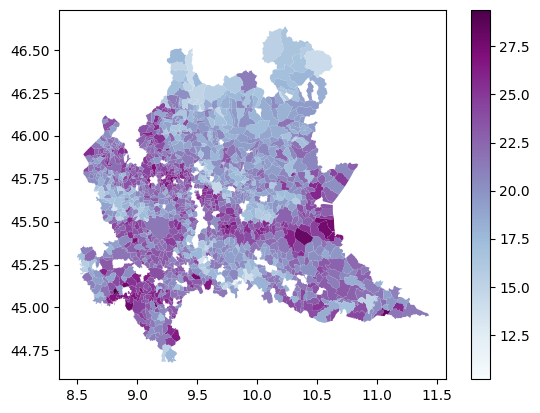

In [12]:
merged_df = merged_df.to_crs(map.crs)
merged_df.plot(column="PM25_predictions", legend=True, cmap="BuPu")